Using mean face landmarks from: lrwar\data\mean_face_landmarks.txt
Using shape predictor from: shape_predictor_68_face_landmarks.dat
Found 10 videos for visualization

Processing video 1/10: 00139.mp4


C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


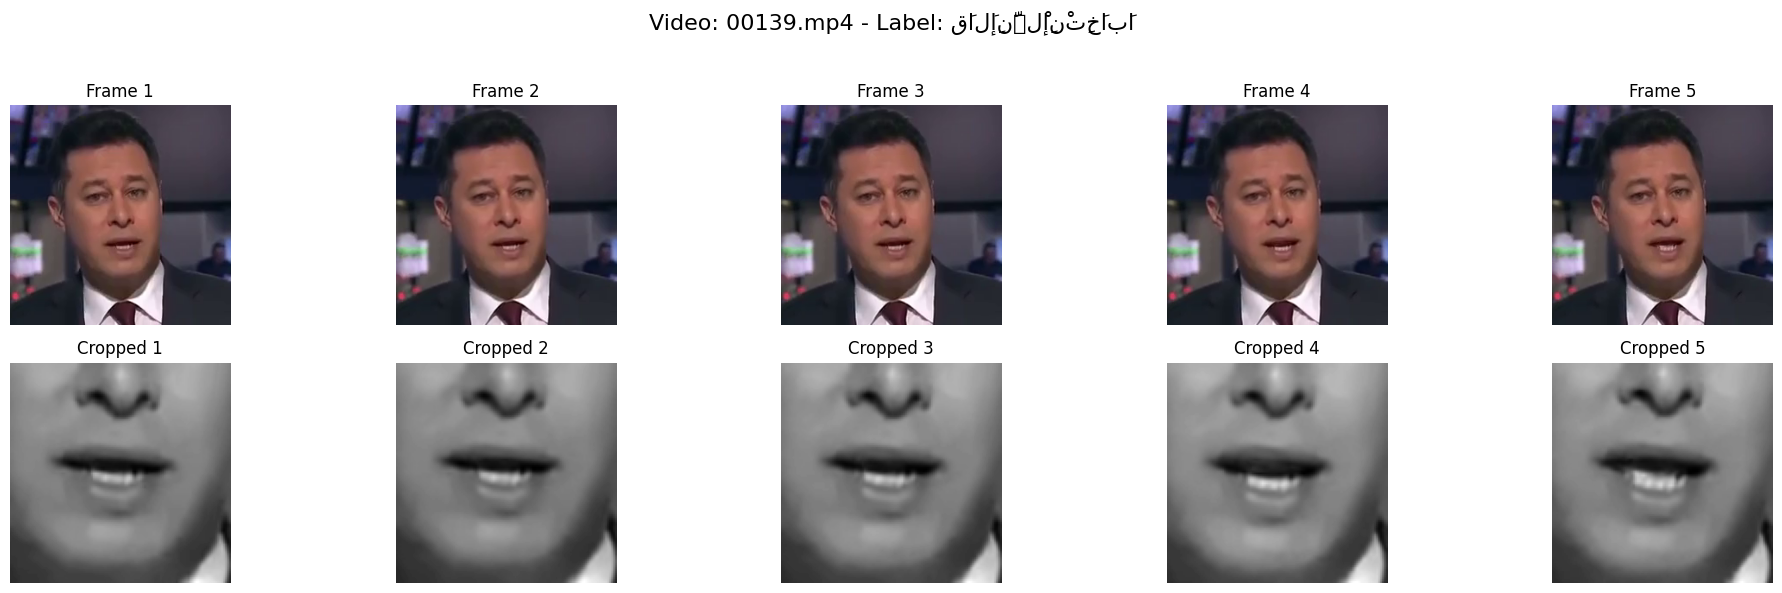


Processing video 2/10: 00154.mp4


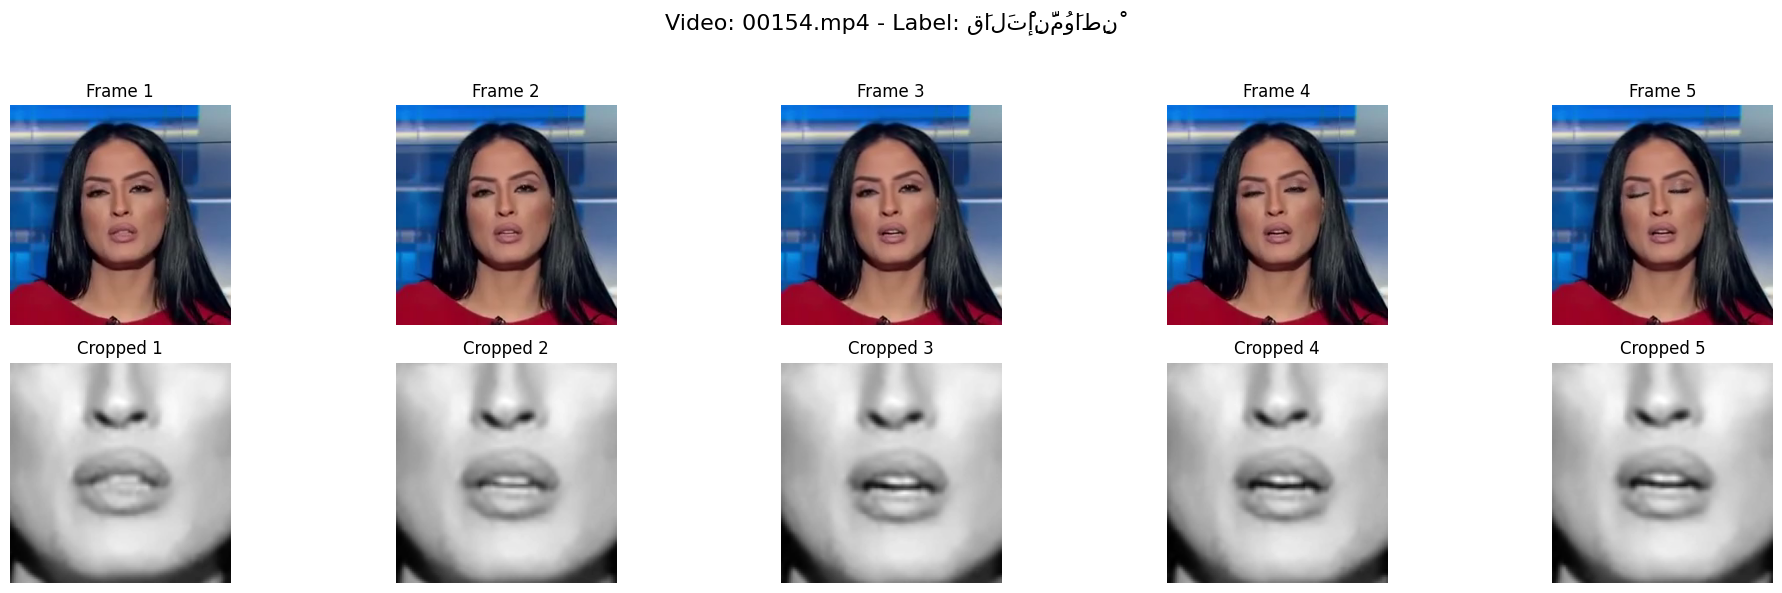


Processing video 3/10: 00156.mp4


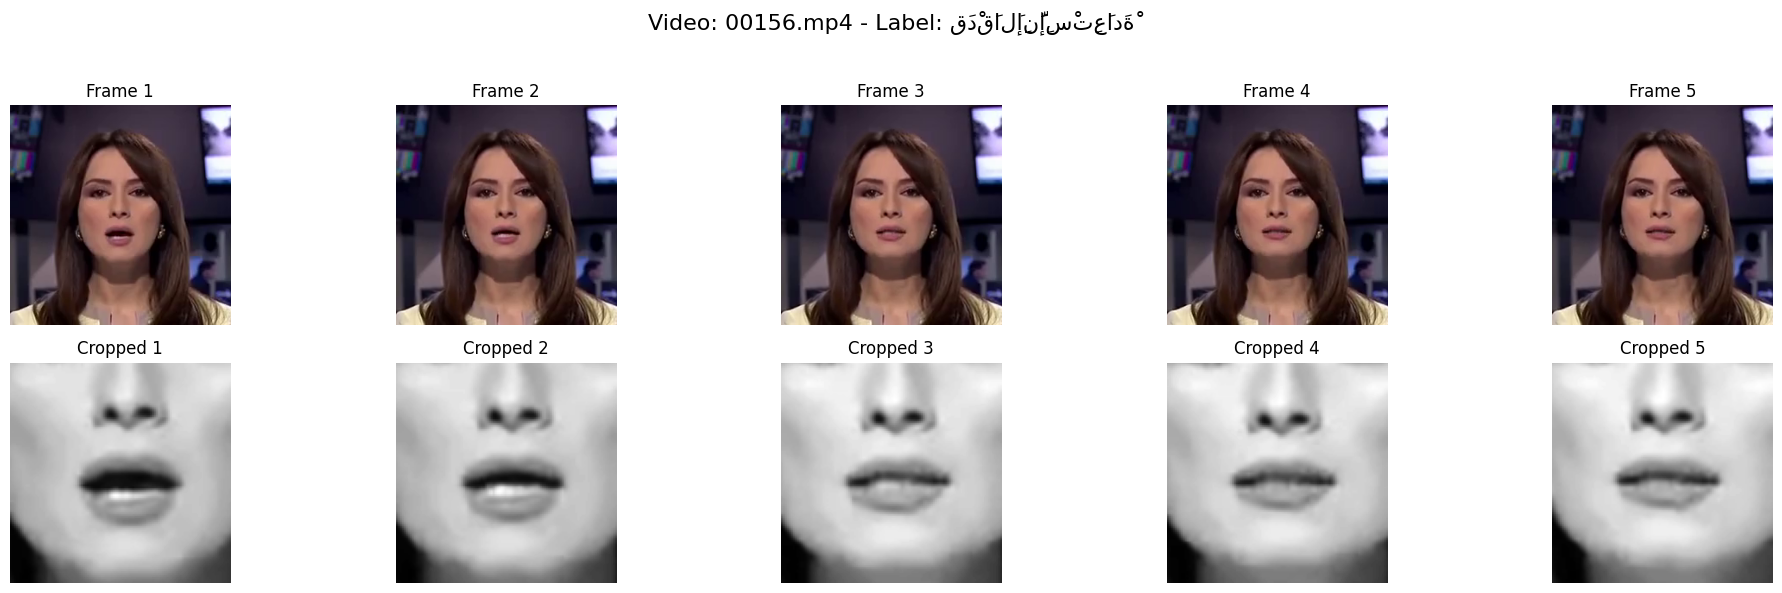


Processing video 4/10: 00157.mp4


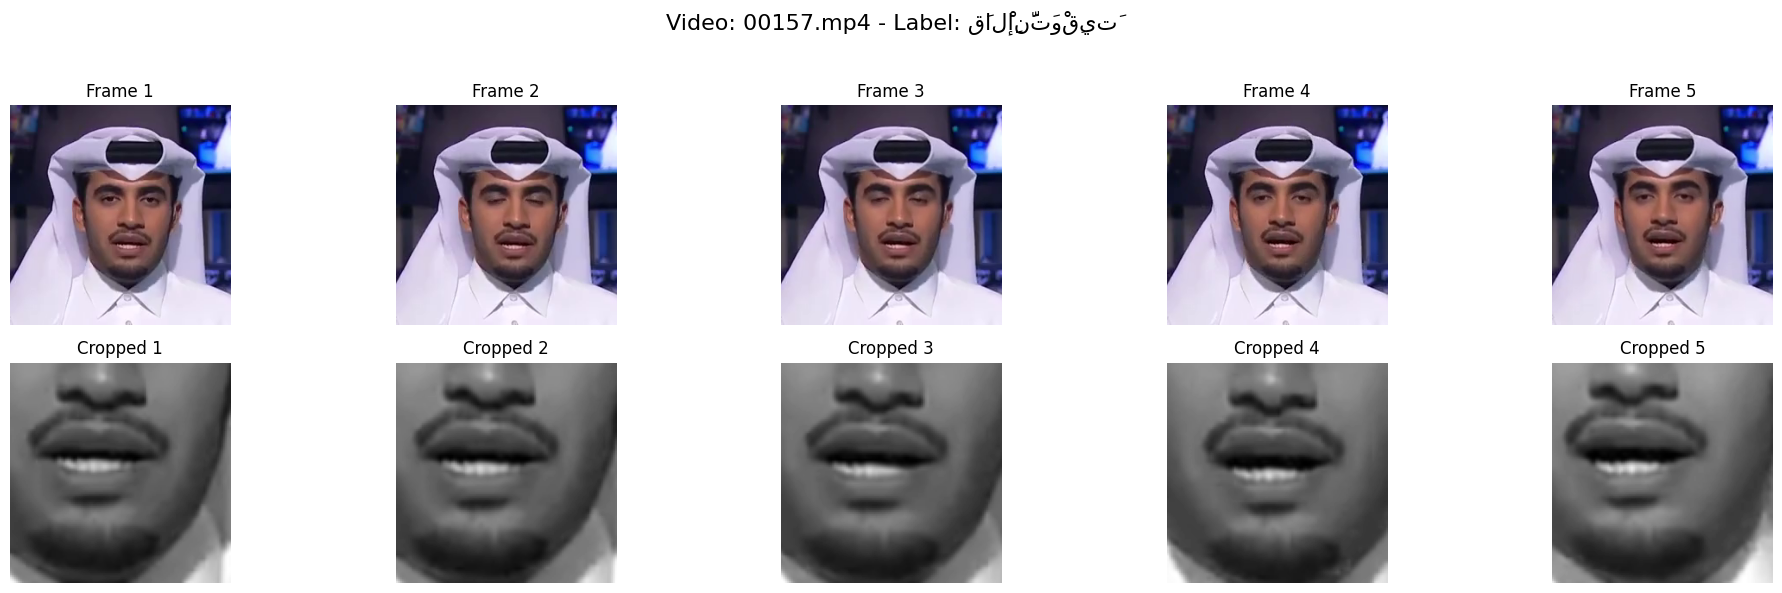


Processing video 5/10: 00158.mp4


C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


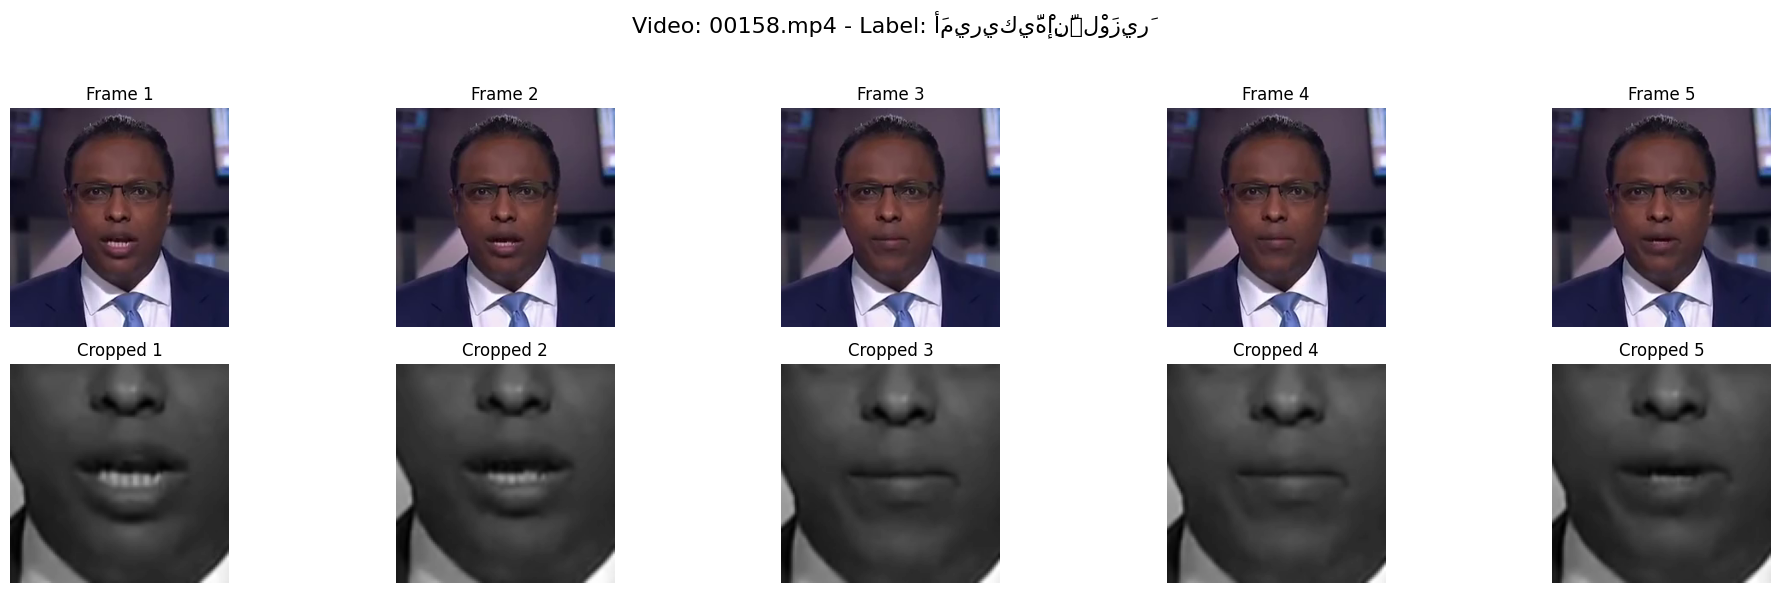


Processing video 6/10: 00159.mp4


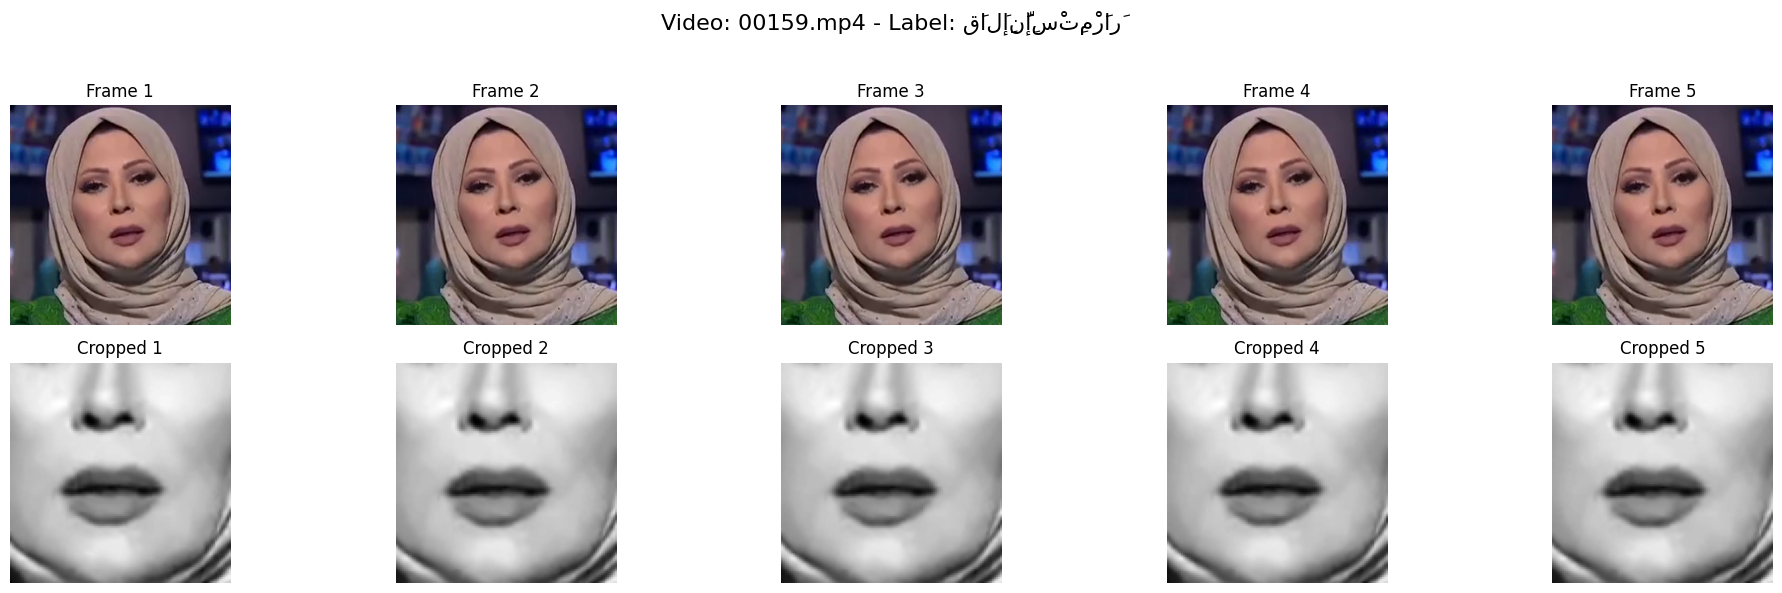


Processing video 7/10: 00160.mp4


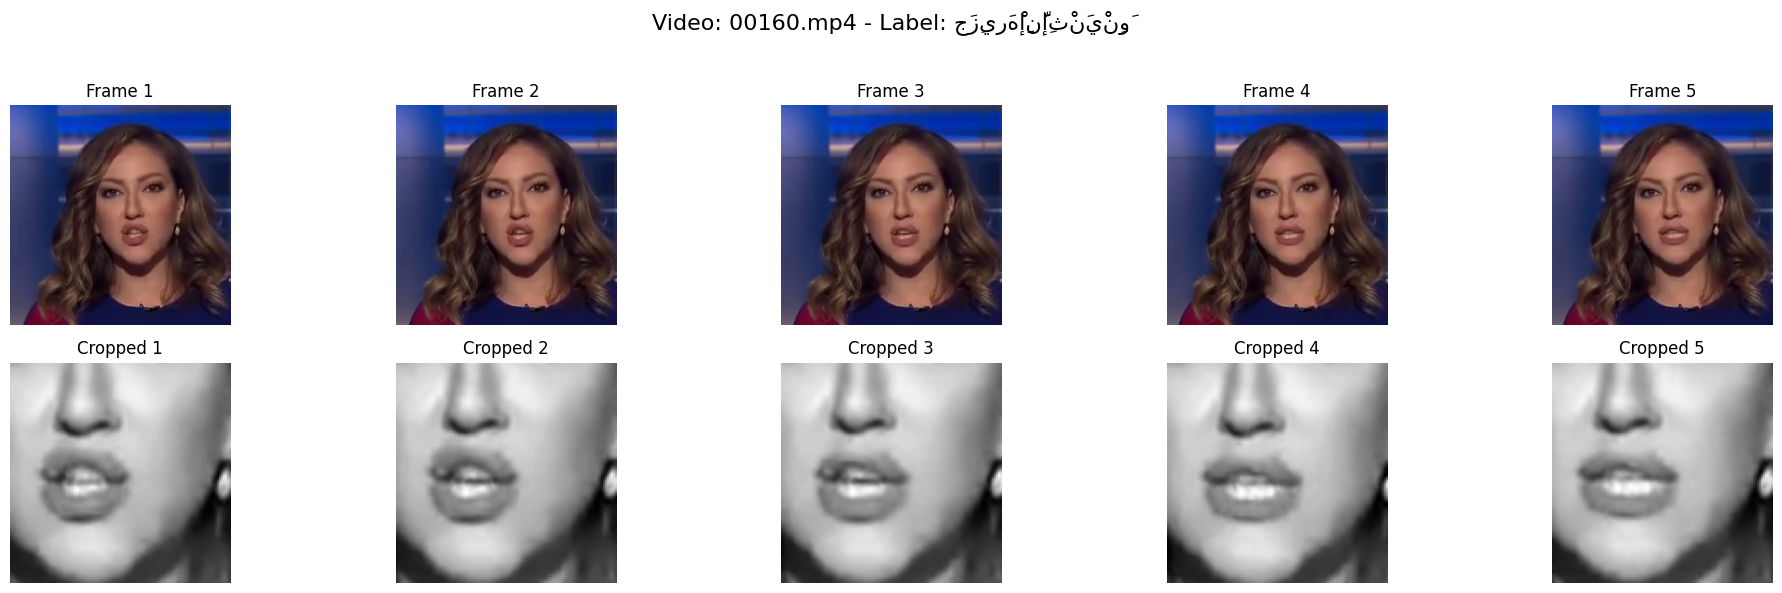


Processing video 8/10: 00161.mp4


C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
C:\Users\hazem\AppData\Local\Temp\ipykernel_15016\2682470315.py:203: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


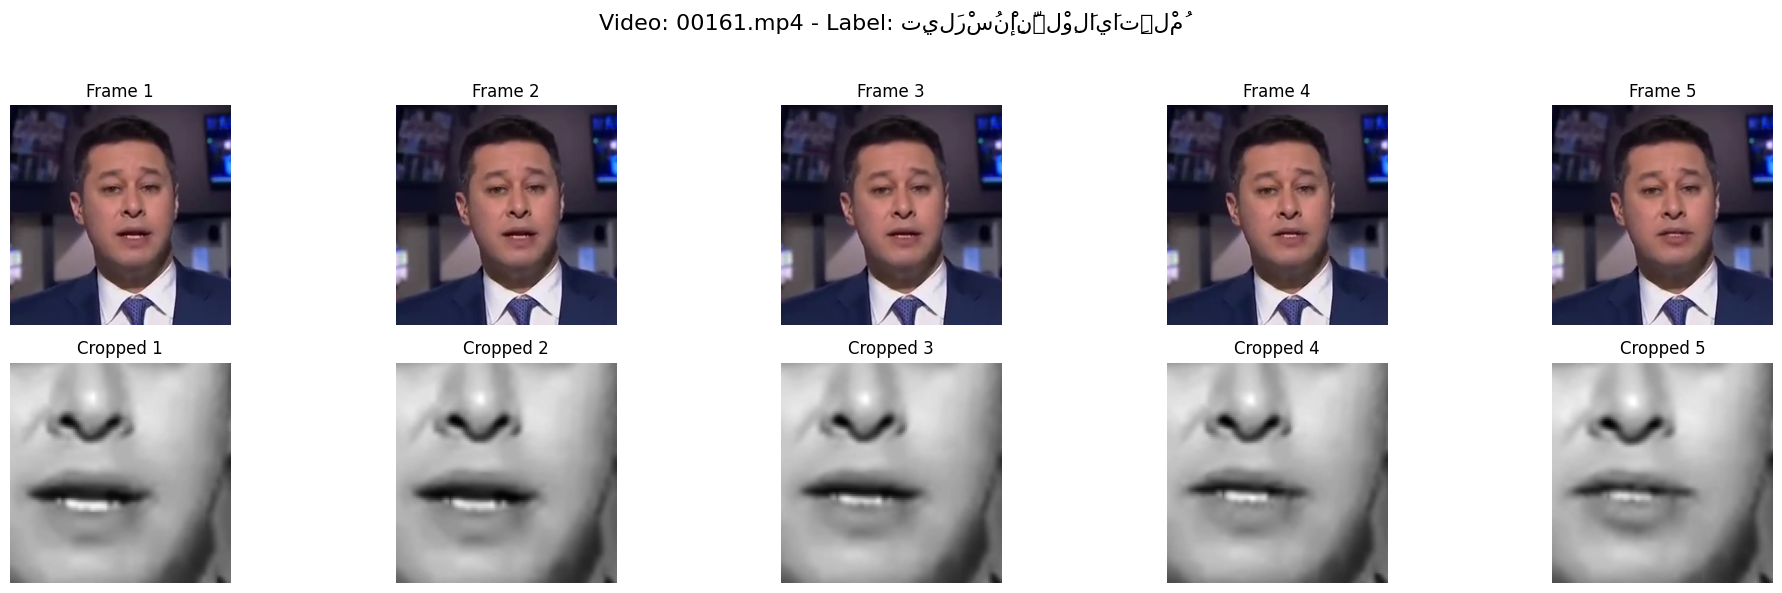


Processing video 9/10: 00162.mp4


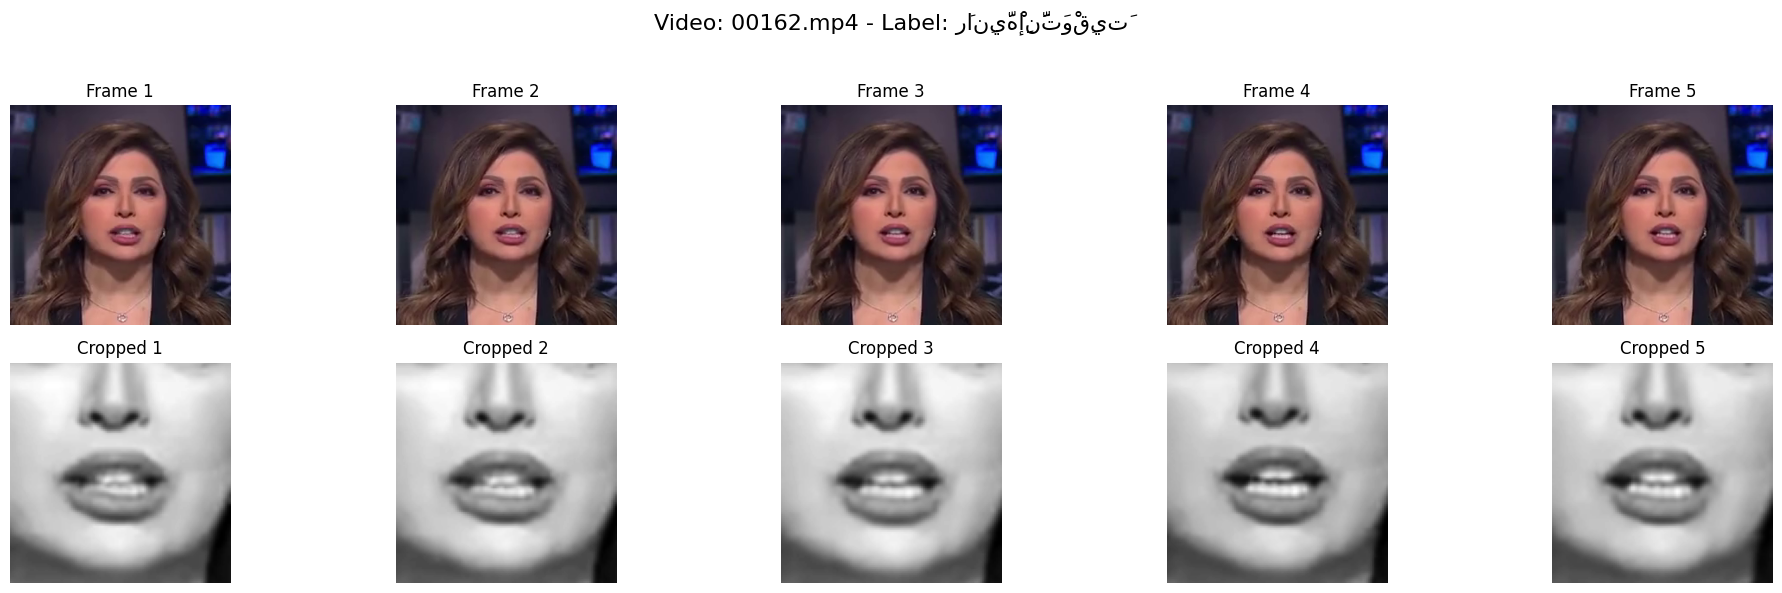


Processing video 10/10: 00163.mp4


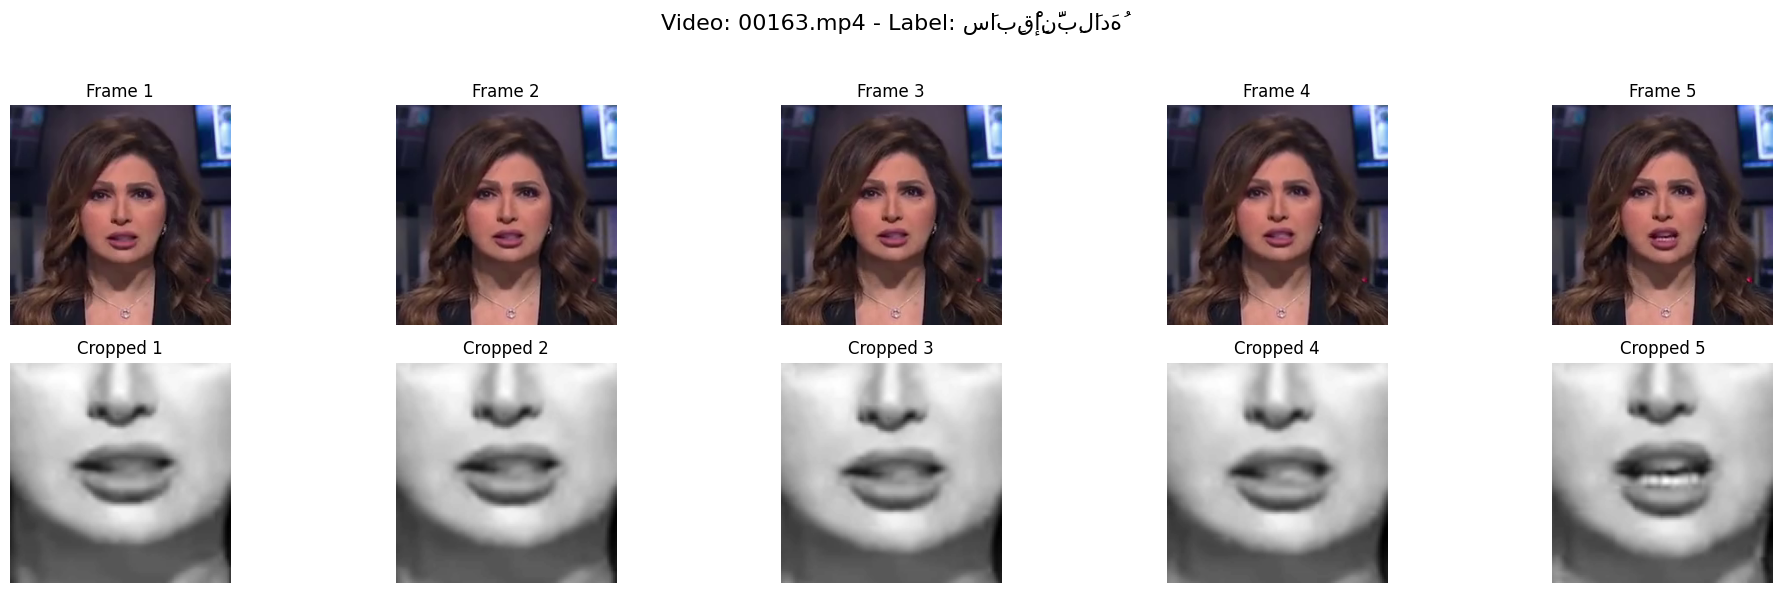

In [ ]:
# Import necessary libraries
import torch, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import dlib
import sys
from collections import deque
from skimage import transform as tf

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['axes.grid'] = False

# Import the necessary functions from master_preprocessed.py
from master_preprocessed import (
    extract_landmarks_from_frame,
    landmarks_interpolate,
    warp_img,
    cut_patch,
    extract_label
)

# Constants for face and mouth ROI extraction
STD_SIZE = (256, 256)
STABLE_POINTS_IDS = [33, 36, 39, 42, 45]  # Stable facial landmarks for alignment
MOUTH_POINTS_START_IDX = 48  # Start index for mouth landmarks
MOUTH_POINTS_END_IDX = 68    # End index for mouth landmarks
CROP_WIDTH = 96   # Width of the mouth ROI
CROP_HEIGHT = 96  # Height of the mouth ROI

# mean_face_landmarks from lrwar
MEAN_FACE_LANDMARKS_PATH = "mean_face_landmarks.txt"

# Initialize face detector and landmark predictor
detector = dlib.get_frontal_face_detector()

predictor_path = "shape_predictor_68_face_landmarks.dat"

print(f"Using shape predictor from: {predictor_path}")
predictor = dlib.shape_predictor(predictor_path)

# Get list of video files
video_files = []
label_files = []

for root, dirs, files in os.walk('Dataset/Video'):
    for file in files:
        if file.endswith('.mp4'):
            video_path = os.path.join(root, file)
            # Construct the corresponding label path
            label_path = os.path.join('Dataset/Csv (with Diacritics)', file.replace('.mp4', '.csv'))
            if os.path.exists(label_path):
                video_files.append(video_path)
                label_files.append(label_path)

# Take only the first 10 videos
video_files = video_files[:10]
label_files = label_files[:10]

print(f"Found {len(video_files)} videos for visualization")

def process_video_for_visualization(video_path, max_frames=5):
    """Process a video and return the first max_frames frames with ROI cropping"""
    # Initialize lists to store results
    original_frames = []
    cropped_frames = []
    
    # Open the video
    cap = cv2.VideoCapture(video_path)
    
    # First pass: extract landmarks for all frames
    video_landmarks = []
    all_frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        all_frames.append(frame.copy())
        # Extract landmarks using our function for single frame
        landmarks = extract_landmarks_from_frame(frame, detector, predictor)
        video_landmarks.append(landmarks)
    
    # Reset video capture
    cap.release()
    
    # Interpolate missing landmarks
    video_landmarks = landmarks_interpolate(video_landmarks)
    if video_landmarks is None or len(video_landmarks) == 0:
        print(f"Warning: No face detected in {video_path}. Skipping.")
        return None, None
    
    # For smoothing landmarks
    smoothing_window = 5
    q_landmarks = deque(maxlen=smoothing_window)
    
    # Process only the first max_frames frames
    for frame_idx in range(min(max_frames, len(all_frames))):
        frame = all_frames[frame_idx]
        original_frames.append(frame.copy())
        
        # Convert to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Add current landmarks to queue for smoothing
        if frame_idx < len(video_landmarks):
            q_landmarks.append(video_landmarks[frame_idx])
        
        # Process frame if we have landmarks
        if len(q_landmarks) > 0:
            # Use mean of landmarks for stability if we have enough, otherwise use what we have
            if len(q_landmarks) == smoothing_window:
                smoothed_landmarks = np.mean(list(q_landmarks), axis=0)
            else:
                smoothed_landmarks = video_landmarks[frame_idx]
            
            try:
                # Align face using stable points
                trans_frame, _ = warp_img(
                    smoothed_landmarks[STABLE_POINTS_IDS, :],
                    mean_face_landmarks[STABLE_POINTS_IDS, :],
                    gray_frame,
                    STD_SIZE
                )
                
                # Cut mouth region
                mouth_roi = cut_patch(
                    trans_frame,
                    smoothed_landmarks[MOUTH_POINTS_START_IDX:MOUTH_POINTS_END_IDX],
                    CROP_HEIGHT//2,
                    CROP_WIDTH//2
                )
                
                # Resize to target size (112x112)
                mouth_roi = cv2.resize(mouth_roi, (112, 112))
                cropped_frames.append(mouth_roi)
                
            except Exception as e:
                print(f"ROI extraction failed for frame {frame_idx} in {video_path}: {e}")
                # Use a blank frame as placeholder
                cropped_frames.append(np.zeros((112, 112), dtype=np.uint8))
    
    return original_frames, cropped_frames

# Process and display each video one by one
for i, (video_path, label_path) in enumerate(zip(video_files, label_files)):
    print(f"\nProcessing video {i+1}/{len(video_files)}: {os.path.basename(video_path)}")
    original_frames, cropped_frames = process_video_for_visualization(video_path)
    
    if original_frames is None or cropped_frames is None:
        continue
    
    # Get the label for the video
    label = extract_label(label_path)
    label_text = ''.join(label)
    
    # Create a figure with two rows: original frames and cropped frames
    fig, axes = plt.subplots(2, len(original_frames), figsize=(20, 6))
    
    # Set the title for the entire figure
    fig.suptitle(f"Video: {os.path.basename(video_path)} - Label: {label_text}", fontsize=16)
    
    # Display original frames in the first row
    for i, frame in enumerate(original_frames):
        axes[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f"Frame {i+1}")
        axes[0, i].axis('off')
    
    # Display cropped frames in the second row
    for i, frame in enumerate(cropped_frames):
        axes[1, i].imshow(frame, cmap='gray')
        axes[1, i].set_title(f"Cropped {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()